# Регрессия 

**Импортируем библиотеки**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf #Импортируем tensorflow
from tensorflow.keras import utils #Для работы с категориальными данными 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет

import pandas as pd
import numpy as np #Для работы с матрицами 
import random #Для генерации случайных чисел 
import matplotlib.pyplot as plt #Для виузализации 
# import datetime, os #Для подсчета времени и работы с файловой системой

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Формирование тестовой и обучающей выборки 



In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/moscow.csv', sep=";") #Загружаем данные в data frame
df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount): 
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0
  
  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро
    
  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс
  
  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку
  
  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте
  
  #ЕСли строка не равна nan  
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0
  
  #Число классов дистанции
  metroDistanceClasses = 7
  
  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14
    
  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""
  
  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа
  
  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):
    
      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1 

        if (floor == floors): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1 
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
    
    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
    
    
  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan
  
  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)
  
  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади
  
  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0
    
  return area

#Полуаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку
  
  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0
  
  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки
  
  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)
  
  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):
  
  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())
  
  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)
  
  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):
  
  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data] 
  yTrain = np.array(costList)
  
  return yTrain

In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

(126268, 14)
(62504, 14)


In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    if (type(currText)!=str): #Проверяем на nan
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return xTrainComments

In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(yTrain.shape)

(62504, 109)
(62504,)


In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

In [ ]:
yScaler = StandardScaler() 
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(xTrainScaled, yTrainScaled, test_size=0.20, random_state=42)
print(X_train.shape[0])
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

50003
(50003, 1)
(12501, 109)
(12501, 1)


**Параметры обучения и оптимизации**

In [ ]:
xTrain = torch.from_numpy(X_train).float()
yTrain = torch.from_numpy(y_train).float()

xTest = torch.from_numpy(X_test).float()
yTest = torch.from_numpy(y_test).float()
print(xTrain)

tensor([[ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3843],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3787],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.2089],
        ...,
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0350],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1348],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1847]])


In [ ]:
inputSize = 109
hidden = 200

batch_size = 100
lr = 0.0001 
epochs = 100

trainData = torch.utils.data.TensorDataset(xTrain,yTrain)
trainLoader = torch.utils.data.DataLoader(dataset=trainData,
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           num_workers=4,)

In [ ]:
class Regression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__() 
        self.layer1 = nn.Linear(inputSize, hidden_size)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
        self.layer2 = nn.Linear(hidden_size, 1)
        #self.linear = nn.Linear(dim = 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        #out = self.linear(out)
        return out

model = Regression(inputSize, hidden)

In [ ]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # оптимизатор
losses = [] # сюда будет добавляться средняя ошибка. Список будем использовать для построения графика
model.train() # переход в режим обучения (опционально)

Regression(
  (layer1): Linear(in_features=109, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
)

Эпоха: [1/100], Ошибка: 0.6802. Ошибка в млн. рублей: 17.8650
Эпоха: [2/100], Ошибка: 0.2053. Ошибка в млн. рублей: 11.3910
Эпоха: [3/100], Ошибка: 0.0469. Ошибка в млн. рублей: 8.3810
Эпоха: [4/100], Ошибка: 0.2227. Ошибка в млн. рублей: 6.3060
Эпоха: [5/100], Ошибка: 0.1305. Ошибка в млн. рублей: 5.7230
Эпоха: [6/100], Ошибка: 0.0538. Ошибка в млн. рублей: 4.0150
Эпоха: [7/100], Ошибка: 0.0121. Ошибка в млн. рублей: 3.9920
Эпоха: [8/100], Ошибка: 0.0085. Ошибка в млн. рублей: 3.0640
Эпоха: [9/100], Ошибка: 0.0090. Ошибка в млн. рублей: 3.4230
Эпоха: [10/100], Ошибка: 0.0071. Ошибка в млн. рублей: 2.9720
Эпоха: [11/100], Ошибка: 0.0245. Ошибка в млн. рублей: 2.8110
Эпоха: [12/100], Ошибка: 0.0128. Ошибка в млн. рублей: 2.7300
Эпоха: [13/100], Ошибка: 0.0045. Ошибка в млн. рублей: 2.7640
Эпоха: [14/100], Ошибка: 0.0104. Ошибка в млн. рублей: 2.6310
Эпоха: [15/100], Ошибка: 0.0077. Ошибка в млн. рублей: 2.8510
Эпоха: [16/100], Ошибка: 0.0248. Ошибка в млн. рублей: 2.4360
Эпоха: [17/100]

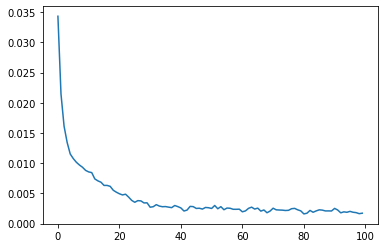

In [ ]:
for epoch in range(epochs): # количество эпох
    lossTot = 0 # потери в совокупности

    batch = 1
    for (data, labels) in trainLoader: # проходимся по всем данным в batch
        label = labels.type(torch.FloatTensor)
        optimizer.zero_grad() # Обнуляем градиент
        outputs = model(data) # Считаем predict
        output = outputs.type(torch.FloatTensor)
        loss = criterion(output, label) # Cчитаем ошибку 
        loss.backward()  # Обратное распространение

        lossTot += loss.detach().data # инкремент ошибки

        predUnscaled = yScaler.inverse_transform(model(xTest[0:100]).detach()).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
        yTrainUnscaled = yScaler.inverse_transform(yTest[0:100]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
        delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
        absDelta = abs(delta) #Берём модуль отклонения
        price_loss = round(sum(absDelta) / (1e+6 * len(absDelta)),3) #Считаем ошибку в миллионах рублей для тестовой выборки

        optimizer.step() # следующий шаг спуска
        batch += 1

    losses.append(lossTot/len(trainData)) # вычисляем среднюю ошибку и добавляем в список

    print('Эпоха: [%d/%d], Ошибка: %.4f. Ошибка в млн. рублей: %.4f' % (epoch+1, epochs, loss, price_loss))
    
plt.plot(losses)
plt.show()